In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
style.use('fivethirtyeight')
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session, sessionmaker
from sqlalchemy import create_engine, func

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [36]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
Session = sessionmaker(bind=engine)
s = Session()

# Exploratory Climate Analysis

### Design a query to retrieve the last 12 months of precipitation data and plot the results

In [38]:
# Calculate the date 1 year ago from the last data point in the database
print(s.query(Measurement.date).order_by(Measurement.date.desc()).first()[0])

2017-08-23


In [39]:
prev_year = dt.date(2017,8,23) - dt.timedelta(days=365)

<Figure size 720x576 with 0 Axes>

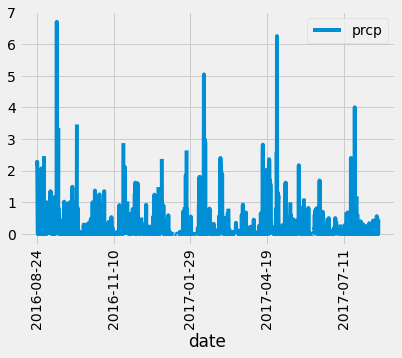

In [41]:
# Perform a query to retrieve the data and precipitation scores
query = s.query(Measurement.date,Measurement.prcp).filter(Measurement.date > prev_year)
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(query)
df.set_index(keys='date',inplace=True)
# Sort the dataframe by date
df.sort_values(by="date",inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10,8))
df.plot(rot=90)
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis
* Design a query to calculate the total number of stations.

In [47]:
# Design a query to show how many stations are available in this dataset?
res = s.query(func.count(Station.station)).all()
f"Unique stations in dataset: {res[0][0]}"

'Unique stations in dataset: 9'

* Design a query to find the most active stations.
    * List the stations and observation counts in descending order.
    * Which station has the highest number of observations?
    * Hint: You will need to use a function such as func.min, func.max, func.avg, and func.count in your queries.

In [48]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
s.query(Measurement.station, func.count(Measurement.date)).group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
station = 'USC00519281'
lowest_temp = s.query(func.min(Measurement.tobs).label('min temp')).filter(Measurement.station == station).one()[0]
print(f"Lowest temperature: {lowest_temp} F")
highest_temp = s.query(func.max(Measurement.tobs).label('max temp')).filter(Measurement.station == station).one()[0]
print(f"Highest temperature: {highest_temp} F")
  
average_temp = s.query(func.avg(Measurement.tobs).label('average temp')).filter(Measurement.station == station).first()[0]
print(f"Average temperature: {average_temp:.2f} F")

Lowest temperature: 54.0 F
Highest temperature: 85.0 F
Average temperature: 71.66 F


Text(0, 0.5, 'Count of Measurements')

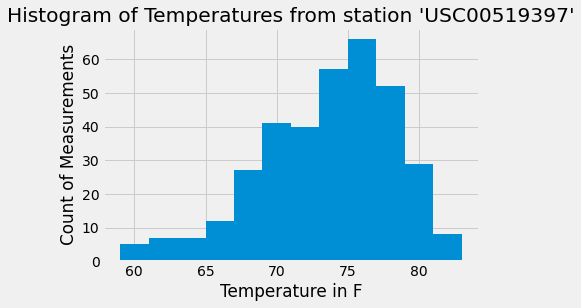

In [52]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
df = pd.DataFrame(s.query(Measurement.tobs).filter(Measurement.date > prev_year).filter(Measurement.station == station))
df.hist(bins=12)
plt.title("Histogram of Temperatures from station 'USC00519397'")
plt.xlabel("Temperature in F")
plt.ylabel("Count of Measurements")

## Bonus Challenge Assignment

In [53]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return s.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [59]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-01-01'
end_date = '2018-01-01'
result = calc_temps(start_date,end_date)[0]
result

(58.0, 74.14387974230493, 87.0)

<BarContainer object of 1 artists>

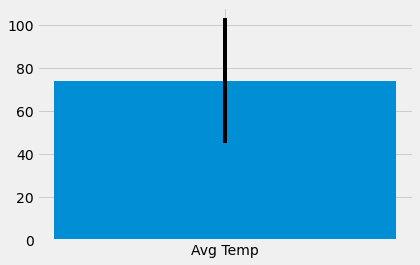

In [60]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.bar("Avg Temp", result[1],yerr=result[2]-result[0])

In [78]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Station.station,Station.name, Station.latitude,Station.longitude,Station.elevation,func.sum(Measurement.prcp)]
results = s.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).\
    all()
print(results)

[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 68.78000000000003), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 43.66000000000002), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 34.62000000000001), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 27.319999999999993), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 21.80000000000002), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 10.659999999999993), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 3.39)]


In [62]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return s.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [91]:
# calculate the daily normals for your trip
print(daily_normals("01-01"))
# push each tuple of calculations into a list called `normals`
normals = daily_normals("01-01")
# Set the start and end date of the trip
start_date = '2018-01-01'
end_date = '2018-01-07'
# Use the start and end date to create a range of dates
date_range = pd.date_range(start=start_date, end=end_date)

# Stip off the year and save a list of %m-%d strings
stripped_dates = [x.strftime("%m-%d") for x in date_range]

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = [daily_normals(x)[0] for x in stripped_dates]

[(62.0, 69.15384615384616, 77.0)]


In [94]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns = ['tmin','tavg','tmax'],index=date_range)
df.head()

,tmin,tavg,tmax
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0


Text(0, 0.5, 'Temperature')

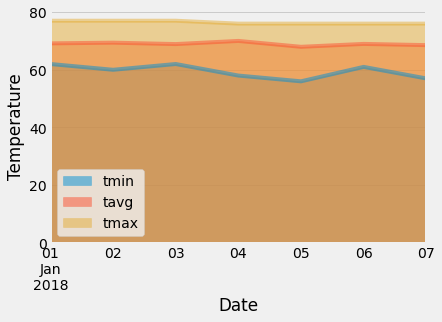

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area',stacked=False)
plt.xlabel("Date")
plt.ylabel("Temperature")